# Exemple 7 : handling NetCDF files and running a simple yield simulation for one year - Brazil 2008

The aim of this notebook is to provide, in response to a user issue (https://github.com/SARRA-cropmodels/SARRA-Py/issues/8), a full working example of simulation performed using data provided in NetCDF format ; also as this example covers Brazil, it cannot use the initially implemented helper functions for the preparation of soil properties data (as they were based on iSDA Africa datasets). Hence, this notebook will prepare a simulation using dummy soil properties values.

## Imports

In [1]:
import numpy as np
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import xarray as xr
from sarra_py import *
import geopandas as gpd

## 1. Defining simulation dates

We begin by defining two key parameters for the simulation: `date_start` and `duration`.

- **`date_start`**: The start date of the simulation. This defines the first day for which data will be loaded and marks the beginning of daily water balance computations. It is recommended to set this date approximately one month before the expected sowing date. This allows the water balance to stabilize before the effective sowing date, which is critical since the emergence phase is triggered by a specific level of soil moisture.

- **`duration`**: The length of the simulation in days. This parameter specifies the number of daily cycles after `date_start` during which computations will run. It determines the time range covered by the simulation and sets the size of the time dimension in the computation arrays. Only the days within the interval `[date_start, date_start + duration]` will be used for calculations.


In [2]:
date_start = datetime.date(2008,5,1)
duration = 220

## 2. Preparing the base dataset (`base_data`)

For this example, we will use data provided by user bducraux for Brazil from 2007 to 2013 in NetCDF format, and will perform an example simulation for year 2008. The URL to the provided data is : https://app.box.com/s/1crdkaowwiwrb1amj5l1clvdw4w7n54w

Once the datasets are manually unzipped, we define the paths to the rainfall and climate variables NetCDF files.

  - `Tmin`: Daily maximum temperature (°C)
  - `Tmax`: Daily minimum temperature (°C)
  - `ET0`: Daily reference evapotranspiration (mm)
  - `solar_radiation_flux_daily`: Daily solar radiation flux (MJ/m²/d)
  - `rainfall` : Daily rainfall (mm)

The spatial extent of the rainfall dataset determines the spatial coverage of the simulation, ensuring that all computations align with the specified geographic area.

In the datasets provided by the user, here the format is NetCDF ; hence we will propose in this notebook to bypass previous data loading functions and directly use NetCDF loading code (thanks to xarray abilities) to work with this file format. Also, as Tmean is not provided, we will compute a proxy of it by taking the mean value of Tmin and Tmax.

In [27]:
# defining the path to the NetCDF datasets
rainfall_data_path = "../data/exemple_data/exemple_7/rain_daily_UT_Brazil_v1_20070101_20131231/rain_daily_UT_Brazil_v1_20070101_20131231.nc"
tmax_data_path = "../data/exemple_data/exemple_7/Tmax_daily_UT_Brazil_v1_20070101_20131231/Tmax_daily_UT_Brazil_v1_20070101_20131231.nc"
tmin_data_path = "../data/exemple_data/exemple_7/Tmin_daily_UT_Brazil_v1_20070101_20131231/Tmin_daily_UT_Brazil_v1_20070101_20131231.nc"
ET0_data_path = "../data/exemple_data/exemple_7/ETo_daily_UT_Brazil_v1_20070101_20131231/ETo_daily_UT_Brazil_v1_20070101_20131231.nc"
solar_radiation_flux_data_path = "../data/exemple_data/exemple_7/Rs_daily_UT_Brazil_v1_20070101_20131231/Rs_daily_UT_Brazil_v1_20070101_20131231.nc"

Next, we determine the dimensions of the gridded rainfall dataset. In SARRA-Py, the spatial resolution of the simulation is determined by the resolution of the rainfall dataset. This ensures that all calculations are aligned with the same grid structure, maintaining consistency across the simulation.


In [ ]:
# We load the netCDF file for rainfall in order to get the size of the computational grid.
# We transpose the axes as the provided file was incorrectly formatted.
rainfall_data = xr.open_dataset(rainfall_data_path).transpose(...,'y', 'x')
grid_width, grid_height = rainfall_data.dims['y'], rainfall_data.dims['x']
print("The grid is {} pixels wide by {} pixels high.".format(grid_width, grid_height))

The grid is 162 pixels wide by 168 pixels high.


/tmp/ipykernel_747/3953428655.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  grid_width, grid_height = rainfall_data.dims['y'], rainfall_data.dims['x']


Finally, we initialize the base xarray dataset, and load the rainfall and climate data. Here and contrary to other example notebooks, we do not rely on the helper functions load_TAMSAT_data and load_AgERA5_data, as the latter were taylored to load datasets as GeoTIFFs series. Thus, we use raw xarray functions to manage the loading of the provided NetCDF datasets.

In [ ]:
# initialize empty xarray dataset
base_data = xr.Dataset()


# Loading the rainfall variable
# Loading rainfall data NetCDF, and subsetting to the dates we need
rainfall_data = rainfall_data["rain"].sel(time=slice(date_start, date_start + datetime.timedelta(days=duration)))
# We put this data into the base_data dataarray, and apply the standard attributes
base_data["rain"] = rainfall_data
base_data["rain"].attrs = {"units":"mm", "long_name":"rainfall"}
# free up memory
del rainfall_data


# Loading the weather variables
# Lading Tmin and Tmax data NetCDF, also applying transposition, and subsetting to the dates we need
tmax_data = xr.open_dataset(tmax_data_path).transpose(...,'y', 'x')
tmax_data = tmax_data["Tmax"].sel(time=slice(date_start, date_start + datetime.timedelta(days=duration)))
tmin_data = xr.open_dataset(tmin_data_path).transpose(...,'y', 'x')
tmin_data = tmin_data["Tmin"].sel(time=slice(date_start, date_start + datetime.timedelta(days=duration)))
# calculating the mean temperature, and putting it into the base_data dataarray
tmean_data = (tmax_data + tmin_data) / 2
base_data["tpMoy"] = tmean_data
# free up memory
del tmax_data
del tmin_data

# Loading ET0 data NetCDF, also applying transposition, and subsetting to the dates we need
ET0_data = xr.open_dataset(ET0_data_path).transpose(...,'y', 'x')
ET0_data = ET0_data["ETo"].sel(time=slice(date_start, date_start + datetime.timedelta(days=duration)))
base_data["ET0"] = ET0_data
# free up memory
del ET0_data

# Loading solar radiation flux data NetCDF, also applying transposition, and subsetting to the dates we need
solar_radiation_flux_data = xr.open_dataset(solar_radiation_flux_data_path).transpose(...,'y', 'x')
solar_radiation_flux_data = solar_radiation_flux_data["Rs"].sel(time=slice(date_start, date_start + datetime.timedelta(days=duration)))
base_data["rg"] = solar_radiation_flux_data
# free up memory
del solar_radiation_flux_data

All the loadings of these files was facilitated by the fact that they were already at the good units and homogeneous spatial projections and dimensions.

Now, we prepare the soil properties dataset. Here, we also cannot rely on the helper function load_iSDA_soil_data as it was destined to load data for the African continent (using iSDA Africa datasets). Here, we then replace this function call with a manual construction of dummy variables for soil properties in Brazil (i.e. the whole country will have homogeneous soil properties), for the purpose of testing. 


In [48]:
# We initialize all the necessary variables with dummy values
# Estimated soil properties from Brazil should be loaded here to get a more realistic simulation.

# profile depth, 500 mm
# here we take the first time step of the rainfall data as reference ot get the correct dimensions
base_data["profRu"] = 500.0 * xr.ones_like(base_data["rain"][0,:,:]) 
base_data["profRu"].attrs = {"units": "mm", "long_name": "Soil root zone depth (mm)"}

# soil surface reservoir depth, 100 mm
# then, we use profRu as a reference for the dimensions of invariant variables
base_data["epaisseurSurf"] = 100.0 * xr.ones_like(base_data["profRu"])
base_data["epaisseurSurf"].attrs = {"units": "mm", "long_name": "Soil surface reservoir depth (mm)"}

# initial water stock in the soil surface reservoir, 50 mm (that sounds a lot)
base_data["stockIniProf"] = 50.0 * xr.ones_like(base_data["profRu"])
base_data["stockIniProf"].attrs = {"units": "mm", "long_name": "Initial water stock in the deep surface reservoir (mm)"}

# runoff rate, 10%
base_data["runoff_rate"] = 0.1 * xr.ones_like(base_data["profRu"])
base_data["runoff_rate"].attrs = {"units": "mm", "long_name": "Runoff rate (mm)"}

# runoff threshold, 10 mm 
base_data["runoff_threshold"] = 10.0 * xr.ones_like(base_data["profRu"])

# RZPAWC, root zone plant available water capacity, 100 mm
base_data["RZPAWC"] = 100.0 * xr.ones_like(base_data["profRu"])
base_data["RZPAWC"].attrs = {"units": "mm", "long_name": "Root zone plant available water capacity (mm)"}

base_data["ru"] = base_data["RZPAWC"] / (base_data["profRu"]/1000)
base_data["ru"].attrs = {"units": "mm", "long_name": "Root zone plant available water (mm)"}

Finally, we compute the day length, which is independent of parameters (and thus needs to be in the base dataset), and is needed in computations.

In [49]:
# compute day length raster
base_data = calc_day_length_raster_fast(base_data, date_start, duration+1)

As we see below, the resulting base dataset is a `xarray.Dataset` object, which contains the rainfall and climate data, as well as the soil parameters. It also contains the day length, which is computed from the latitude of the location.

In [50]:
base_data

<xarray.Dataset> Size: 145MB
Dimensions:           (x: 168, y: 162, time: 221)
Coordinates:
  * x                 (x) float32 672B -74.12 -73.88 -73.62 ... -32.62 -32.38
  * y                 (y) float32 648B -34.12 -33.88 -33.62 ... 5.875 6.125
  * time              (time) datetime64[ns] 2kB 2008-05-01 ... 2008-12-07
Data variables:
    rain              (time, y, x) float32 24MB ...
    tpMoy             (time, y, x) float32 24MB nan nan nan nan ... nan nan nan
    ET0               (time, y, x) float32 24MB ...
    rg                (time, y, x) float32 24MB ...
    profRu            (y, x) float32 109kB 500.0 500.0 500.0 ... 500.0 500.0
    epaisseurSurf     (y, x) float32 109kB 100.0 100.0 100.0 ... 100.0 100.0
    stockIniProf      (y, x) float32 109kB 50.0 50.0 50.0 ... 50.0 50.0 50.0
    runoff_rate       (y, x) float32 109kB 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    runoff_threshold  (y, x) float32 109kB 10.0 10.0 10.0 ... 10.0 10.0 10.0
    RZPAWC            (y, x) float32 109kB 100.0 100.0 100.0 ... 100.0 100.0
    ru                (y, x) float32 109kB 200.0 200.0 200.0 ... 200.0 200.0
    dureeDuJour       (time, y, x) float64 48MB 10.71 10.71 ... 11.78 11.78

## 3. Preparing a simulation dataset (`data`)

In this section, we will be loading simulation-specific parameters, and preparing a simulation dataset accordingly.

First, we will load the variety parameters file (`file_paramVariete`), the agricultural itinerary parameters file (`file_paramITK`) as well as the soil parameters file (`file_paramTypeSol`) by calling the `load_YAML_parameters` function. All these files can be found commented in the `./data/params/` folder. We incite you to make copies of the provided examples and play around with parameters by calling your copies.

In [51]:
# parameter file names (files are located in the ../data/parameters/ folder)
file_paramVariete = "millet_variety.yaml"
file_paramITK = "millet_niger_2017.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# populate param variables with variety, cropping system and soil parameters
paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

# we will force a value for the sowing date, so that we do not need to update the example file
paramITK["DateSemis"] = datetime.date(2008,5,1)

Once the parameters are loaded, we build up the simulation dataset `data` by copying the base dataset `base_data`, and feeding it with the simulation-specific parameters.

In [52]:
# creating simulation xarray dataset `data` by copying the base data
data = base_data.copy()

# initializing all the necessary variables
data = initialize_simulation(data, grid_width, grid_height, duration+1, paramVariete, paramITK, date_start)
data = initialize_default_irrigation(data)
data = calculate_once_daily_thermal_time(data, paramVariete)

In [53]:
# dropping the coordinates from the time dimension as computations are performed using int indices
data = data.drop("time")

/tmp/ipykernel_747/3342873258.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data = data.drop("time")


The resulting dataset `data` is a `xarray.Dataset` object, which contains all initialized variables for computations.

## 4. Running the model

Once the dataset is built, the model can be run by simply calling the `run_model` function. This function will perform the computations, and return an updated `xarray.Dataset` `data` object containing the results.

In [54]:
data = run_model(paramVariete, paramITK, paramTypeSol, data, duration)

  0%|          | 0/220 [00:00<?, ?it/s]

100%|██████████| 220/220 [12:55<00:00,  3.52s/it]


## 5. Mapping results

Display of the results is backed by the xarray plotting capacities. Because all intermediate calculation variables are stored in the `data` xarray object, we can plot whatever variable used in the calculation, for whatever time point. The list of variables which can be plotted can be accessed by displaying the contents of the data object, section "data variables".

In [55]:
data

<xarray.Dataset> Size: 3GB
Dimensions:                      (x: 168, y: 162, time: 221)
Coordinates:
  * x                            (x) float32 672B -74.12 -73.88 ... -32.38
  * y                            (y) float32 648B -34.12 -33.88 ... 5.875 6.125
Dimensions without coordinates: time
Data variables: (12/110)
    rain                         (time, y, x) float32 24MB ...
    tpMoy                        (time, y, x) float32 24MB nan nan ... nan nan
    ET0                          (time, y, x) float32 24MB ...
    rg                           (time, y, x) float32 24MB ...
    profRu                       (y, x) float32 109kB 500.0 500.0 ... 500.0
    epaisseurSurf                (y, x) float32 109kB 100.0 100.0 ... 100.0
    ...                           ...
    sumPP                        (time, y, x) float32 24MB 0.0 0.0 ... 0.0 0.0
    TigeUp                       (time, y, x) float32 24MB 0.0 0.0 ... 0.0 0.0
    UBTCulture                   (time, y, x) float32 24MB 0.0 0.0 ... 0.0 0.0
    lai                          (time, y, x) float32 24MB nan nan ... nan nan
    Ncrit                        (time, y, x) float32 24MB nan nan ... 0.0 0.0
    irrigation                   (time, y, x) float32 24MB nan nan ... nan nan

### 5.1 Plotting a time series of evolution of phenological phasing

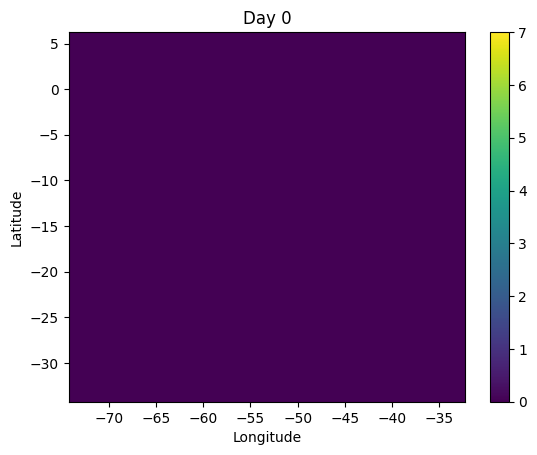

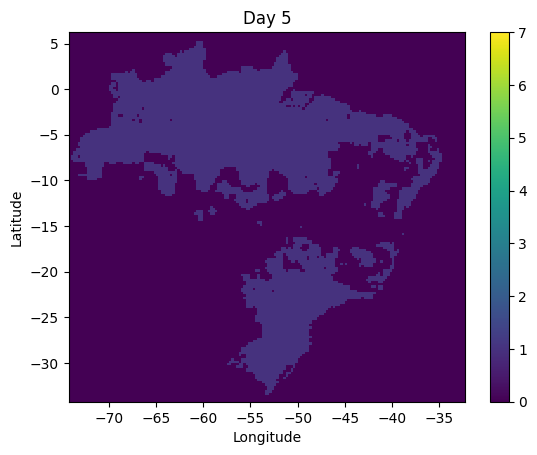

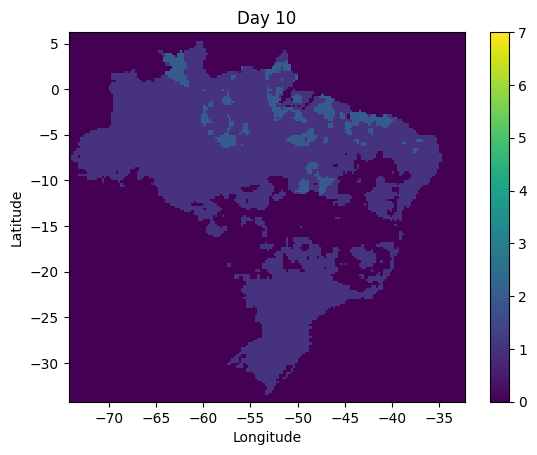

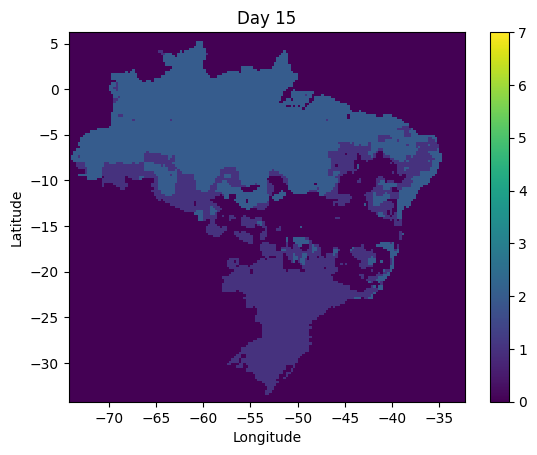

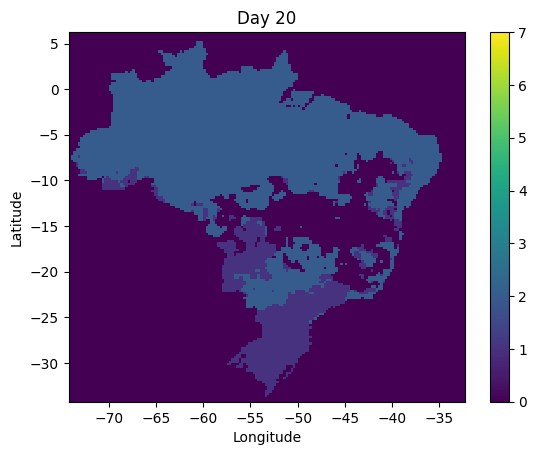

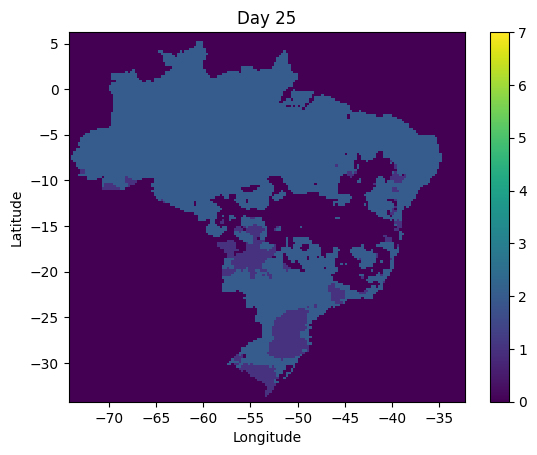

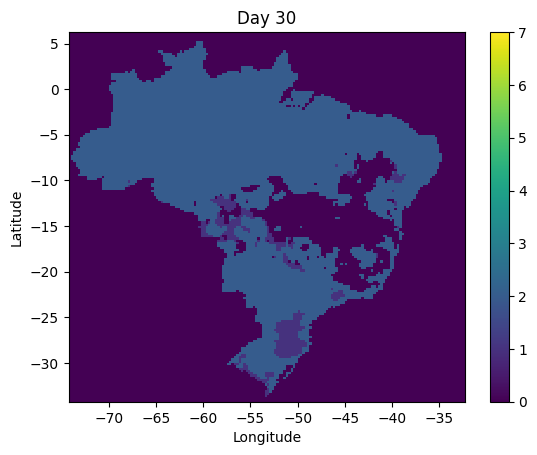

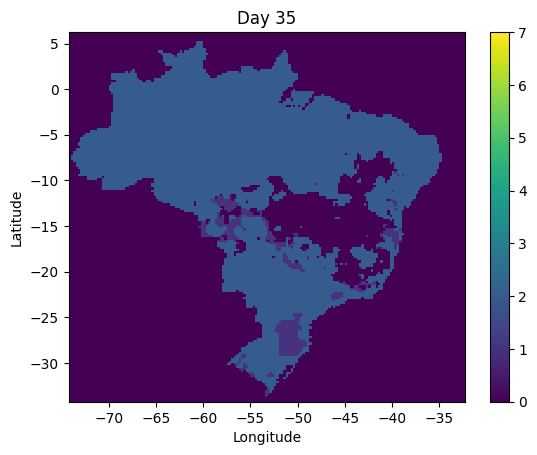

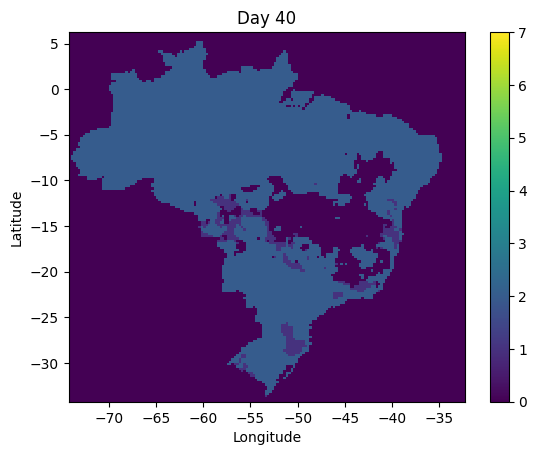

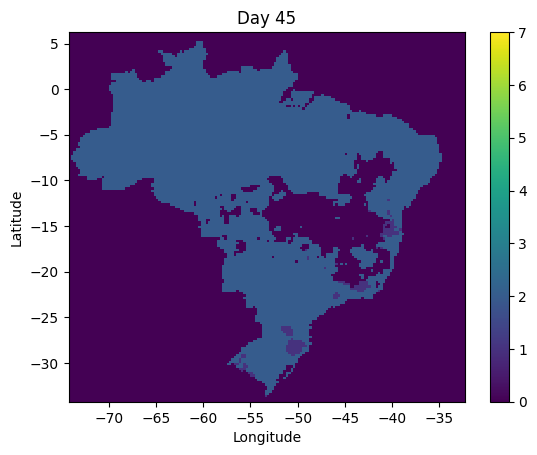

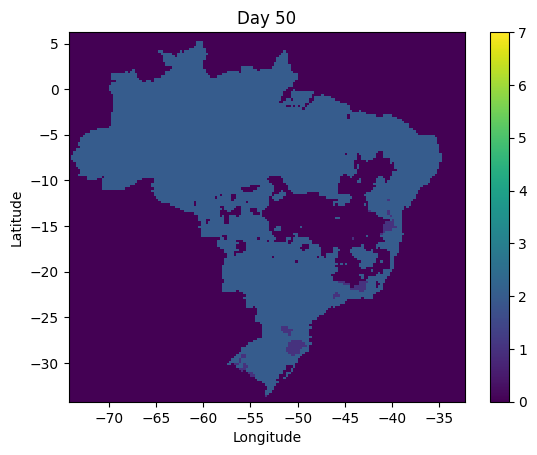

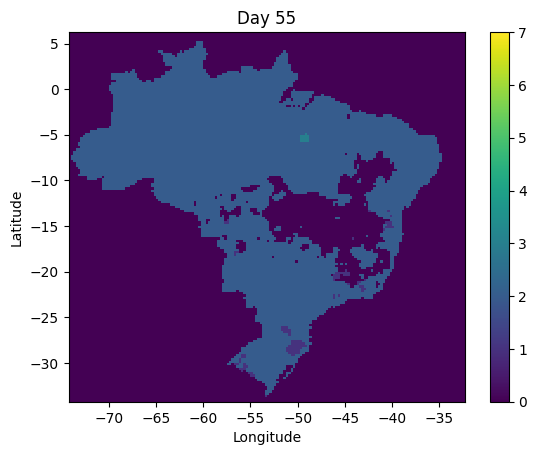

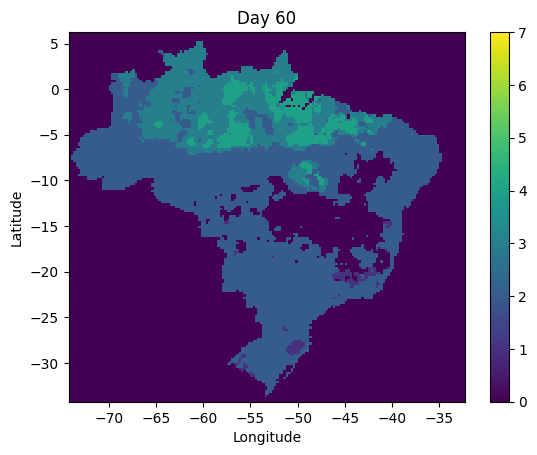

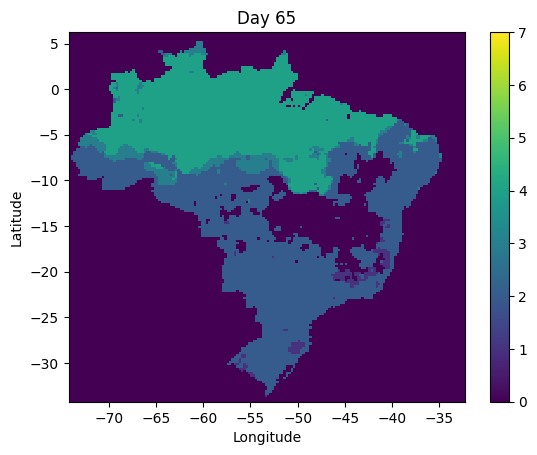

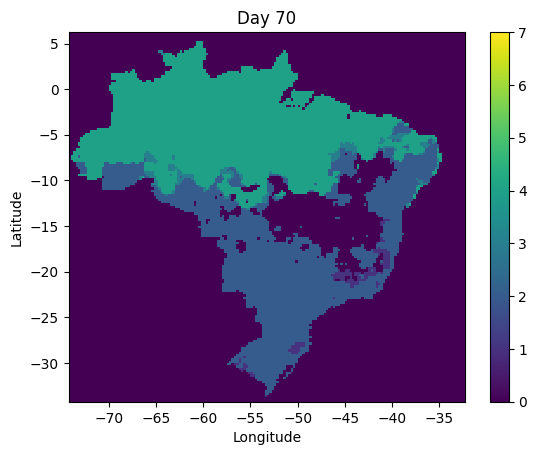

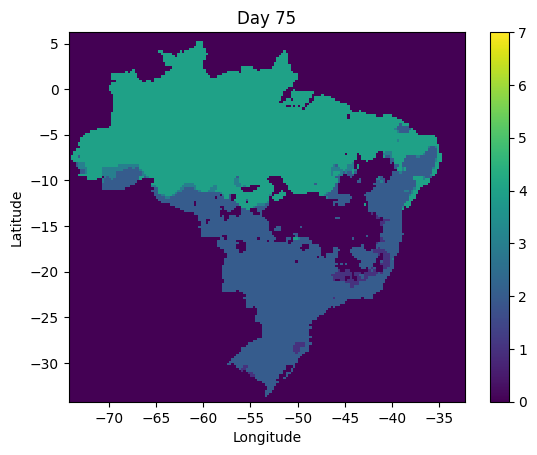

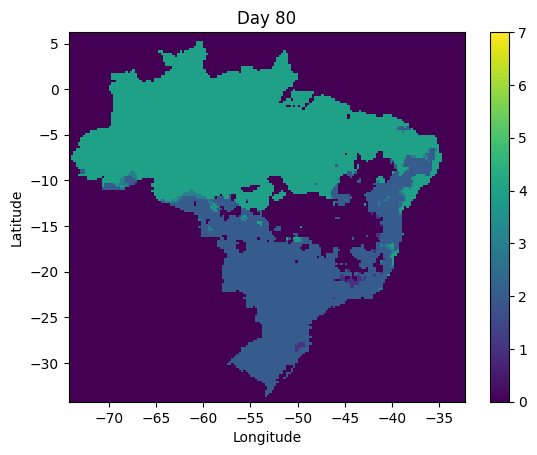

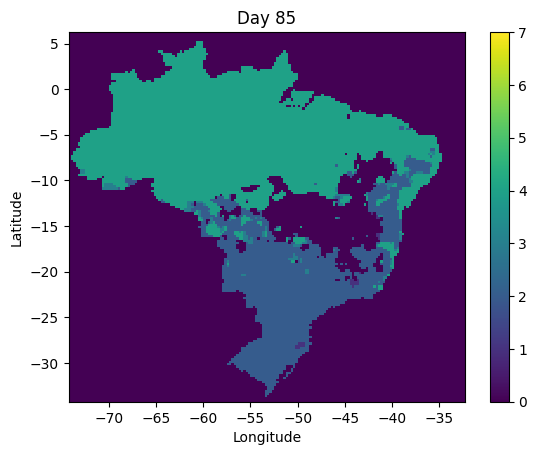

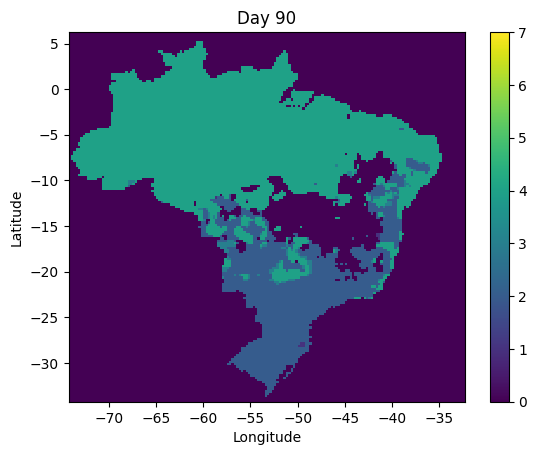

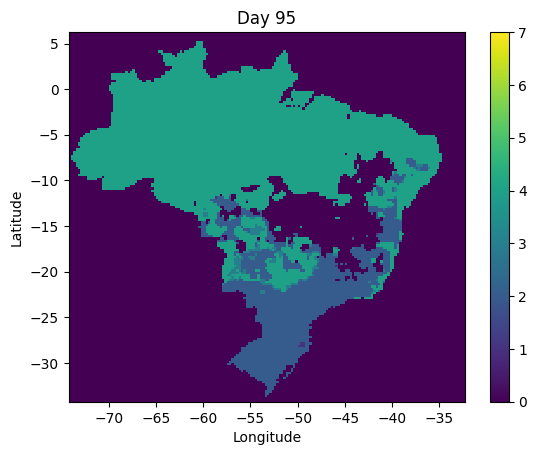

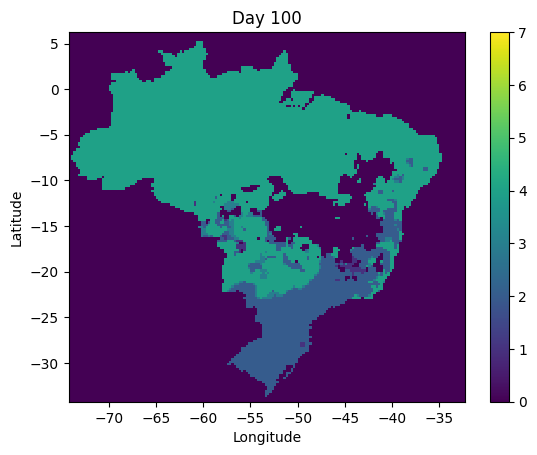

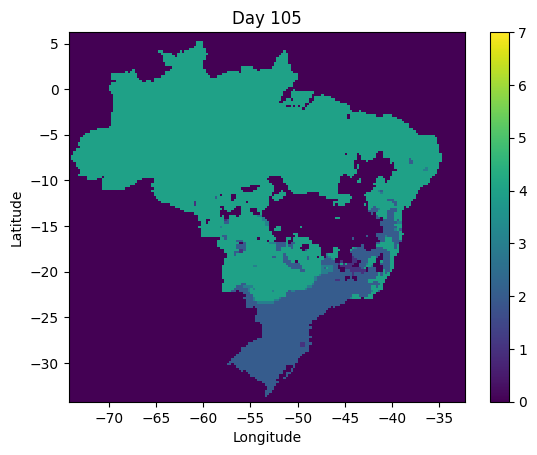

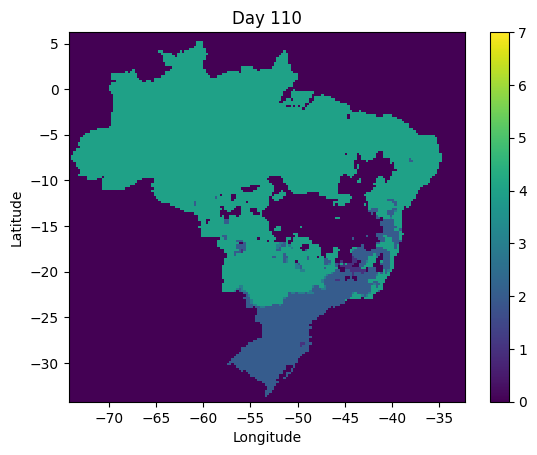

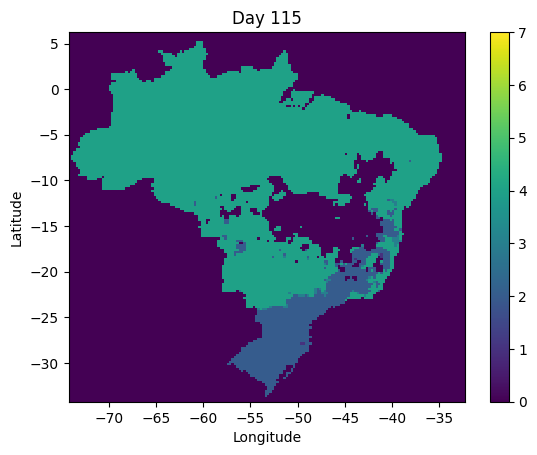

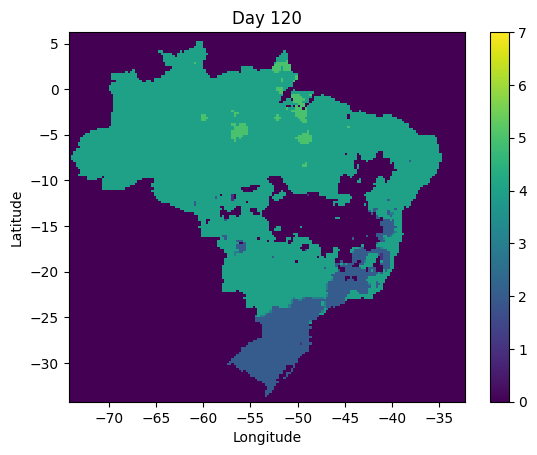

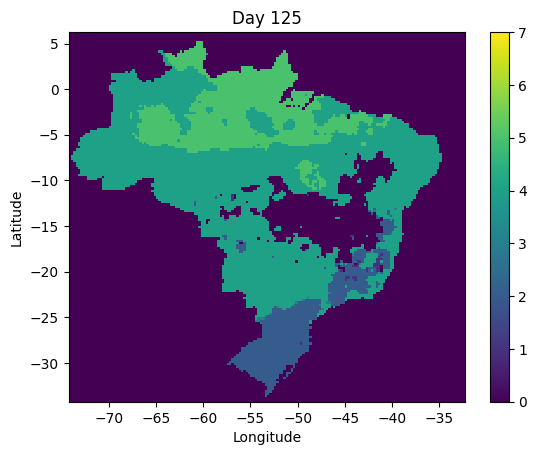

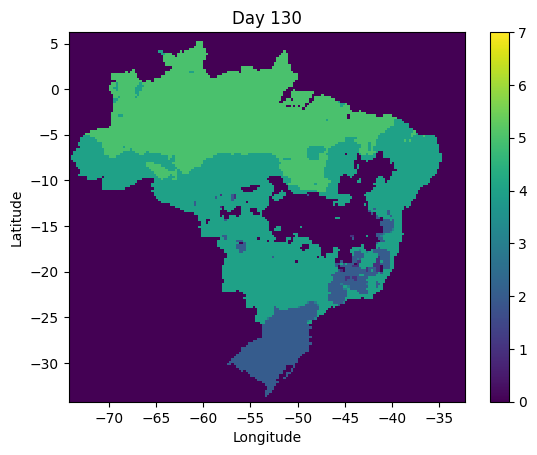

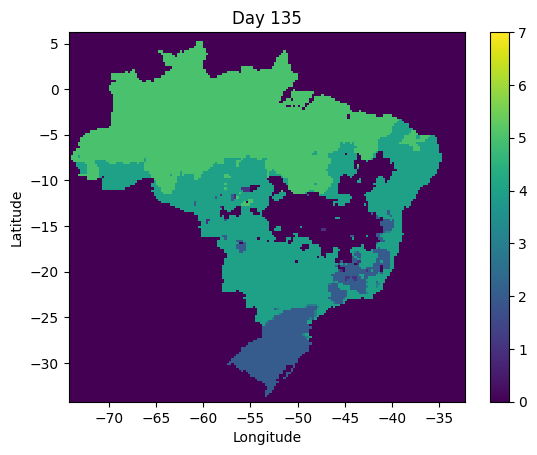

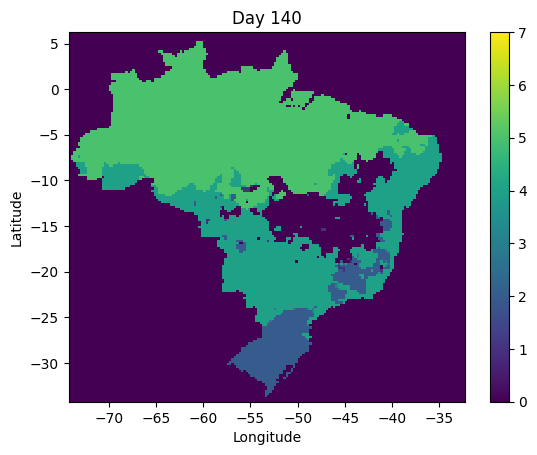

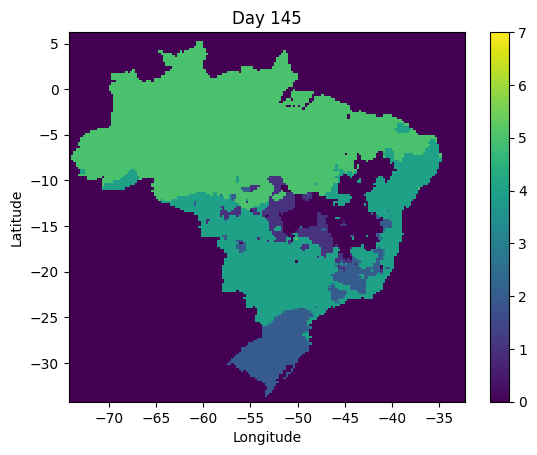

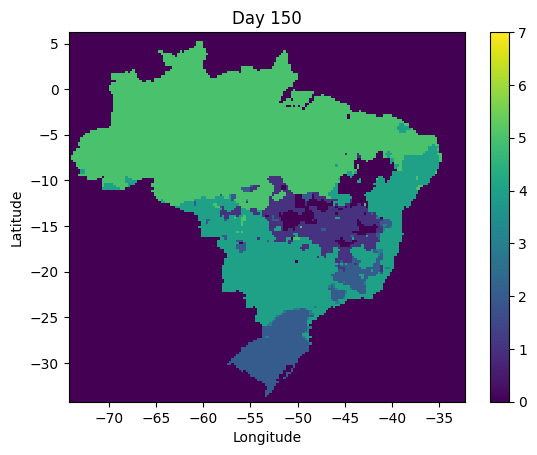

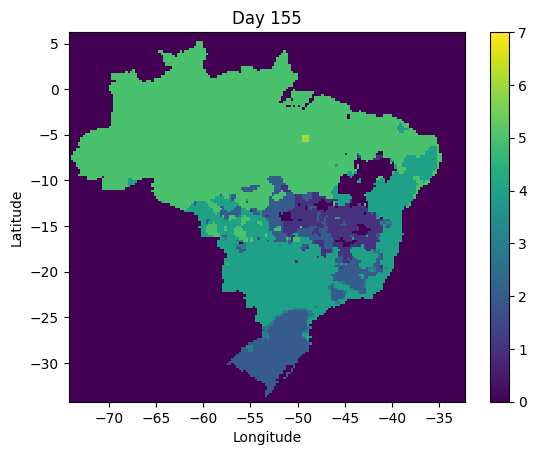

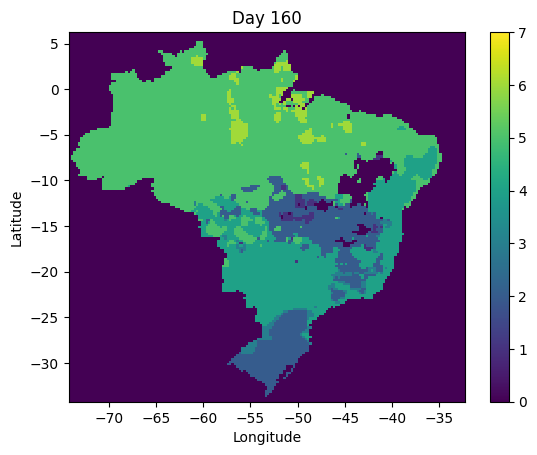

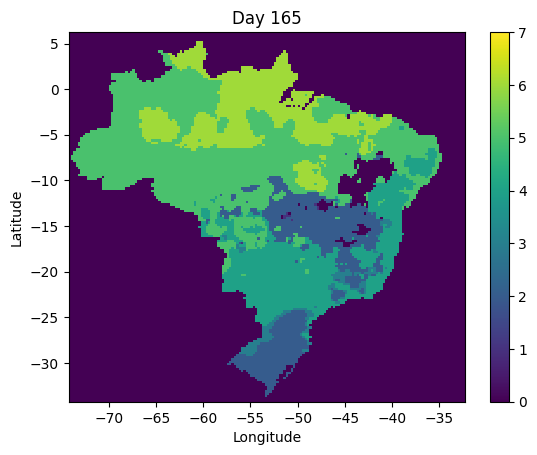

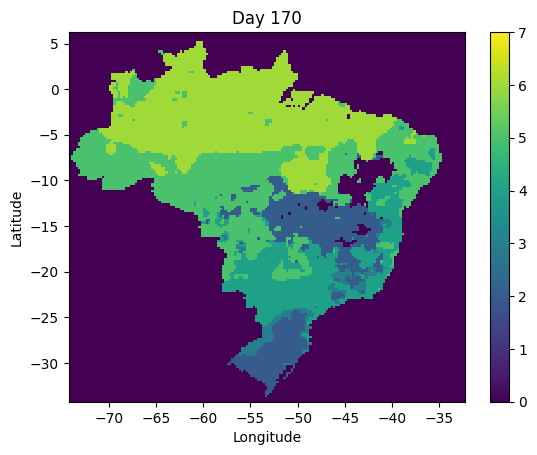

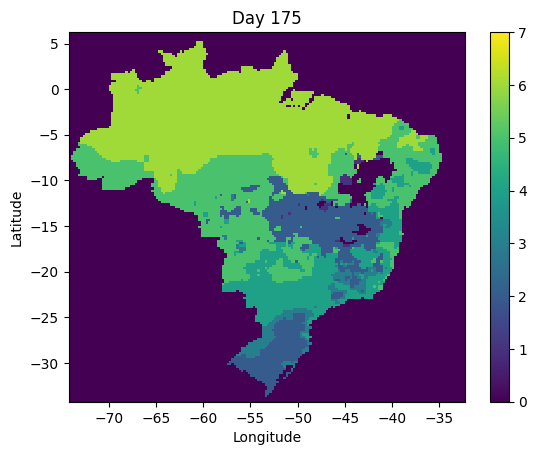

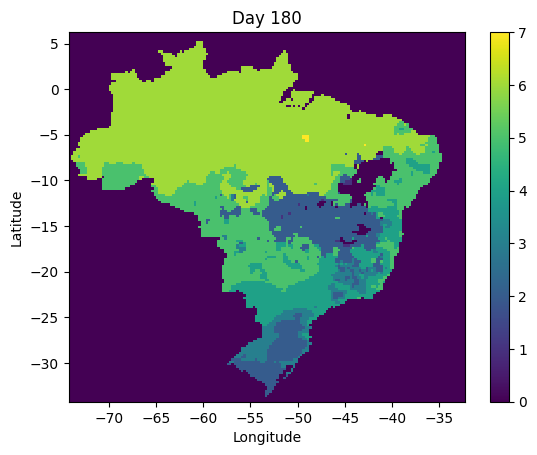

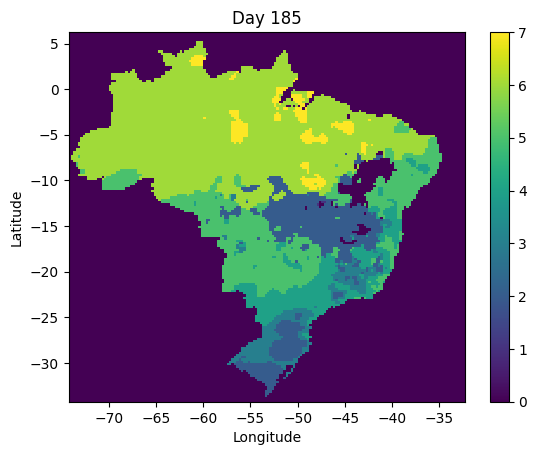

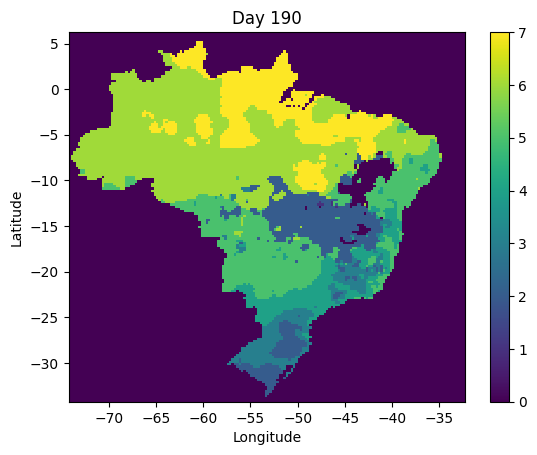

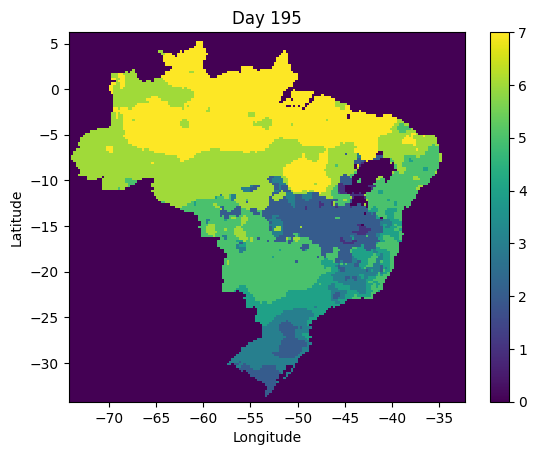

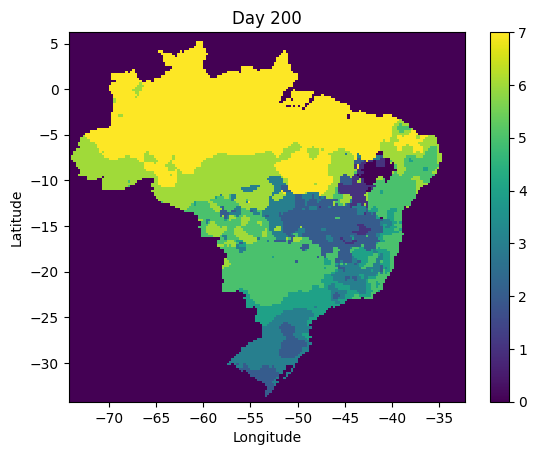

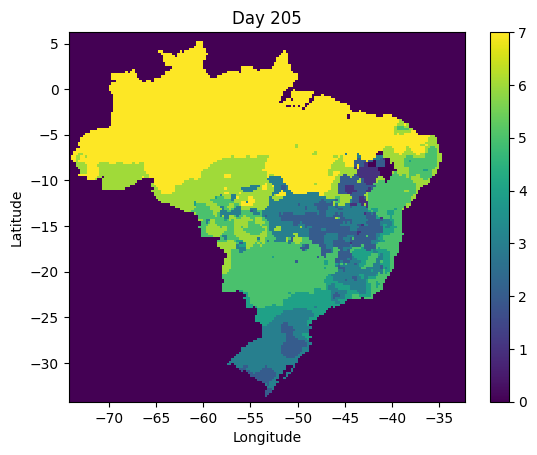

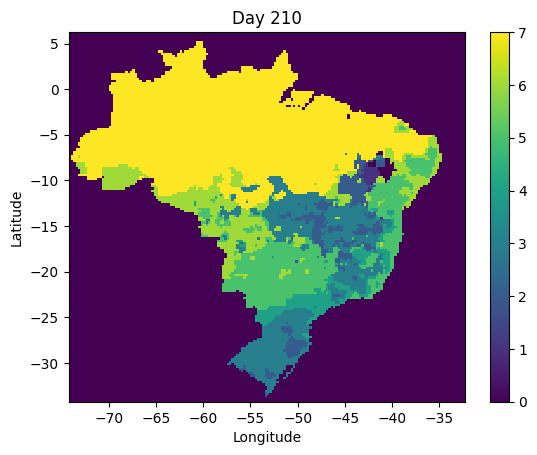

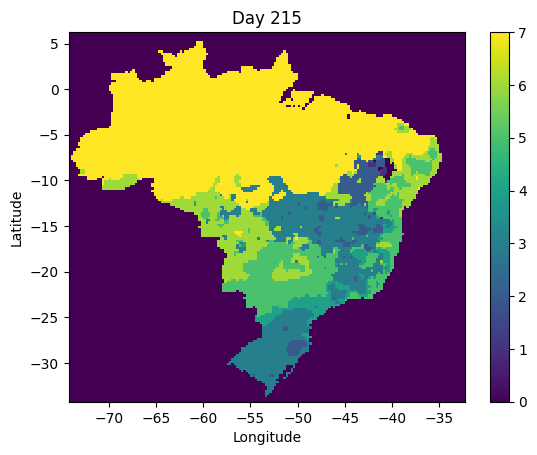

In [57]:
variable = "numPhase" # we define the variable we want to plot, here the number of phenological phase (0 to 7)
time_resolution = 5 # we will make a plot every 5 days
vmax = data[variable].max().values # we define the maximum value for the colorbar

# we loop over the time steps and plot the variable
for i in range(int(round(duration/time_resolution, 0))):
    xr.where(np.isnan(data["ru"]),np.nan,data[variable][time_resolution*i,:,:]).plot(vmin=0, vmax=vmax)
    plt.title("Day %s" % (i*time_resolution))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

### 5.2 Plotting endpoint simulated yield

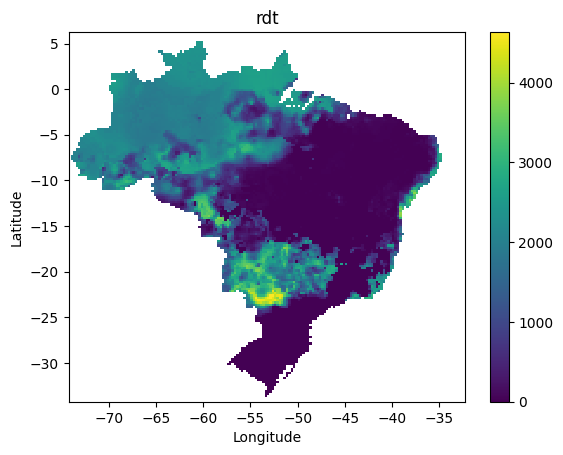

In [59]:
variable = "rdt" # we define the variable we want to plot, here the yield (rendement), in kg/ha

# we plot the variable at the last time step
xr.where(np.isnan(data["ru"]),np.nan,data[variable][-1,:,:]).plot()
plt.title("%s" % (variable))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()